In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,Adamax

In [38]:
aneurysm = ['/kaggle/input/computed-tomography-ct-of-the-brain/files/aneurysm']
cancer = ['/kaggle/input/computed-tomography-ct-of-the-brain/files/cancer']
tumor = ['/kaggle/input/computed-tomography-ct-of-the-brain/files/tumor']
file_p = []
labels = []
dict_lists = [aneurysm, cancer,tumor]
class_labels = ['aneurysm', 'cancer','tumor']

for i, dir_list in enumerate(dict_lists):
     for j in dir_list:
            list_f = os.listdir(j)
            for name in list_f:
                fpath = os.path.join(j, name)
                file_p.append(fpath)
                labels.append(class_labels[i])


failpath = pd.Series(file_p, name="filepaths")
Labelss = pd.Series(labels, name="labels")
data = pd.concat([failpath, Labelss], axis=1)
df = pd.DataFrame(data)

In [39]:
df.head()

,filepaths,labels
0,/kaggle/input/computed-tomography-ct-of-the-br...,aneurysm
1,/kaggle/input/computed-tomography-ct-of-the-br...,aneurysm
2,/kaggle/input/computed-tomography-ct-of-the-br...,aneurysm
3,/kaggle/input/computed-tomography-ct-of-the-br...,aneurysm
4,/kaggle/input/computed-tomography-ct-of-the-br...,aneurysm


In [40]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42,stratify=df.labels)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42,stratify=train_df.labels)
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(329, 2)
(130, 2)
(59, 2)


In [41]:
def enhance_image(image):
    image = cv2.addWeighted(image, 1.5, image, -0.5, 0)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    hue = image[:, :, 0]
    saturation = image[:, :, 1]
    value = image[:, :, 2]
    value = np.clip(value * 1.25, 0, 255)

    image[:, :, 2] = value

    return image

In [42]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda image: enhance_image(image))
train = image_gen.flow_from_dataframe(dataframe= train_df,x_col="filepaths",y_col="labels",
                                      target_size=(256,256),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=64,
                                      shuffle=False            
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_df,x_col="filepaths", y_col="labels",
                                     target_size=(256,256),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=64,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_df,x_col="filepaths", y_col="labels",
                                    target_size=(256,256),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=64,
                                    shuffle=False
                                   )

Found 161 validated image filenames belonging to 3 classes.
Found 68 validated image filenames belonging to 3 classes.
Found 30 validated image filenames belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 168 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 62 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 29 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [43]:
!pip install pydicom Pillow


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Error reading file /kaggle/input/computed-tomography-ct-of-the-brain/files/aneurysm/69.jpg: 'FileMetaDataset' object has no attribute 'TransferSyntaxUID'
Error reading file /kaggle/input/computed-tomography-ct-of-the-brain/files/aneurysm/83.jpg: 'FileMetaDataset' object has no attribute 'TransferSyntaxUID'
Error reading file /kaggle/input/computed-tomography-ct-of-the-brain/files/aneurysm/61.jpg: 'FileMetaDataset' object has no attribute 'TransferSyntaxUID'
Error reading file /kaggle/input/computed-tomography-ct-of-the-brain/files/cancer/25.jpg: 'FileMetaDataset' object has no attribute 'TransferSyntaxUID'
Error reading file /kaggle/input/computed-tomography-ct-of-the-brain/files/cancer/65.jpg: 'FileMetaDataset' object has no attribute 'TransferSyntaxUID'
Error reading file /kaggle/input/computed-tomography-ct-of-the-brain/files/cancer/70.jpg: 'FileMetaDataset' object has no attribute 'TransferSyntaxUID'
Error reading file /kaggle/input/computed-tomography-ct-of-the-brain/files/cancer/

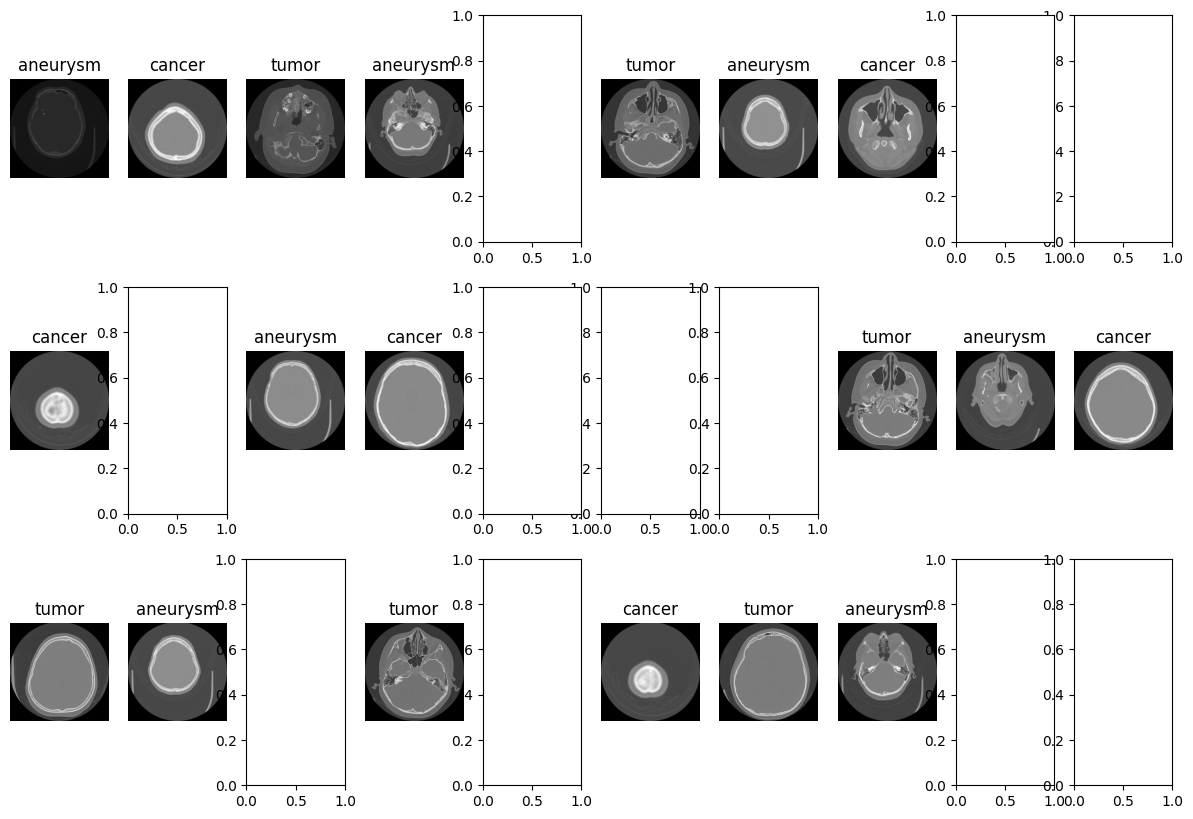

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pydicom
from PIL import Image

# Define the number of images to display from each class
num_images_per_class = 10

# Get class labels
class_labels = list(train.class_indices.keys())

# Plot images from each class
plt.figure(figsize=(15, 10))
for label in class_labels:
    # Get indices of images belonging to the current class
    indices = train_df[train_df['labels'] == label].index
    
    # Randomly sample a subset of indices if there are more than the desired number of images per class
    indices = np.random.choice(indices, min(num_images_per_class, len(indices)), replace=False)
    
    # Plot images
    for i, idx in enumerate(indices):
        plt.subplot(len(class_labels), num_images_per_class, len(class_labels)*i + class_labels.index(label) + 1)
        
        file_path = train_df.loc[idx, 'filepaths']
        
        # Attempt to read the DICOM file with force=True
        try:
            dicom_file = pydicom.dcmread(file_path, force=True)
            image = dicom_file.pixel_array  # Get the image data as a numpy array
            plt.imshow(image, cmap=plt.cm.gray)  # Display in grayscale
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            continue  # Skip this file and continue with the next one
        
        plt.title(label)
        plt.axis('off')
plt.show()


In [45]:
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception

learning_rate = 0.001
base_model = Xception(weights='imagenet', include_top=False, pooling='max')
x = base_model.output
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adamax(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train, epochs=30, validation_data=val)


Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 62s 10s/step - accuracy: 0.5435 - loss: 1.1701 - val_accuracy: 0.5667 - val_loss: 1.8690
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 713ms/step - accuracy: 0.9268 - loss: 0.1800 - val_accuracy: 0.8333 - val_loss: 0.6928
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 594ms/step - accuracy: 0.9808 - loss: 0.0528 - val_accuracy: 0.8667 - val_loss: 0.6981
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 580ms/step - accuracy: 0.9848 - loss: 0.0348 - val_accuracy: 0.8667 - val_loss: 0.6464
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 576ms/step - accuracy: 0.9790 - loss: 0.0390 - val_accuracy: 0.8667 - val_loss: 0.5553
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 564ms/step - accuracy: 0.9751 - loss: 0.0350 - val_accuracy: 0.8667 - val_loss: 0.4722
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 582ms/step - accuracy: 0.9731 - loss: 0.0524 - val_accuracy: 0.9000 - val_loss: 0.4272
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 573ms/step - accuracy: 0.9969 - loss: 0.0116 - val_accuracy: 0.9000 - val_loss: 0.3943
Epoc

In [46]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9850 - loss: 0.1654
Test Loss: 0.16203783452510834
Test Accuracy: 0.9852941036224365


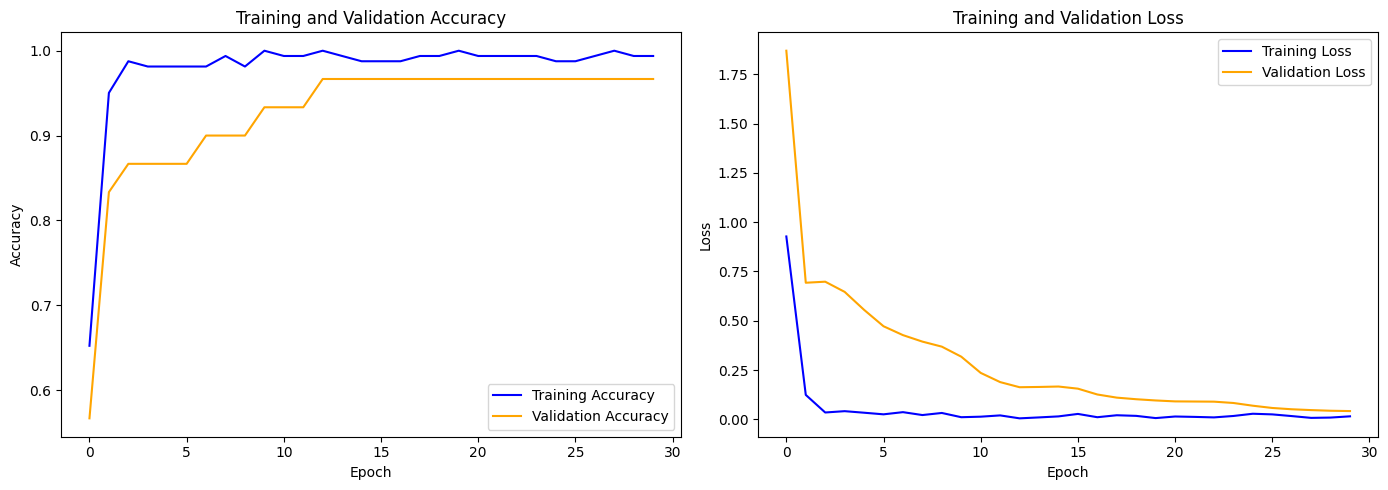

In [47]:
import matplotlib.pyplot as plt

# Retrieve accuracy and loss data from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a figure with two subplots: one for accuracy and one for loss
plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


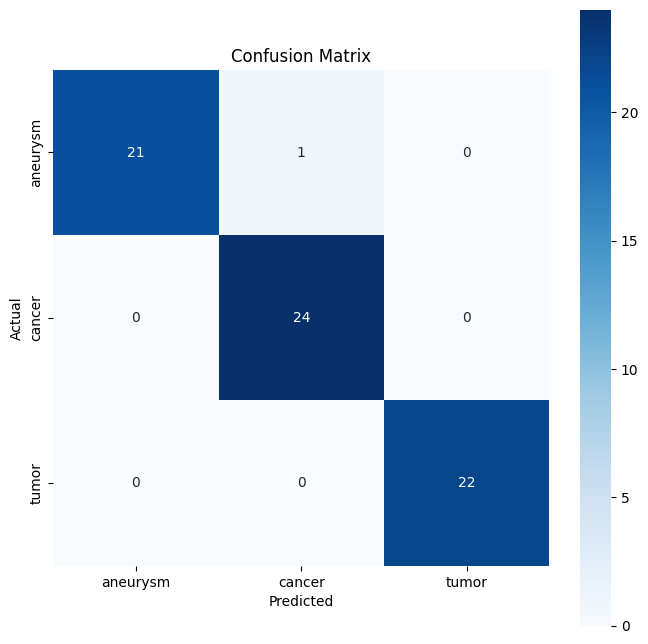

In [48]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions for the test data
y_pred = model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = test.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True, 
            xticklabels=test.class_indices.keys(), yticklabels=test.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
